In [1]:
from nutils import *
import numpy, unittest

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

In [2]:
nelems = 10
degree = 1
tol  = 1e-5
ndims = 1
extent = 1
h = extent / nelems
weak_bc = True
v = 100    # convective velocity
k = 1      # diffusivity

In [3]:
domain, geom = mesh.rectilinear([numpy.linspace(0,extent,nelems+1)]*ndims)

# prepare residual
ns = function.Namespace()
ns.pi = numpy.pi
ns.x = geom
ns.basis = domain.basis('discont', degree=degree)
ns.u = 'basis_n ?lhs_n'
ns.h = h
ns.v = v
ns.k = k
# stabilization parameter
if ns.k == 0:
    ns.tau = ' h / (2 v)'
else:
    ns.peclet = ' 0.5 v h / k'
    ns.tau = ' ((cosh(peclet) / sinh(peclet)) - (1 / peclet)) h / (2 v) '
ns.D = 1       # continuity penalty coefficient
ns.C = ' v '   # upwinding coefficient
ns.ext = extent

In [4]:
# BCs and RHS

# u(x) = [(gr-gl)/(exp(v/k) - 1)] [exp((v/k) x) - 1] + gl
# u'(x)= (v/k)[(gr-gl)/(exp(v/k) - 1] [exp((v/k) x)]
#   with u(0) = gl, u(extent) = gr 
ns.f = 0
ns.gl = 1
ns.gr = 0
# Catch potential overflow exceptions
if(numpy.exp(v/k) == float('inf')):
    # exp(v/k) -> infinity (triggers overflow exception)
    ns.dgl = ' 0 '
    ns.dgr = '(v / k) (gr - gl) exp(ext)'
else:
    ns.dgl = '(v / k) ( (gr - gl) / (exp(v / k) - 1) )'
    ns.dgr = '(v / k) ( (gr - gl) / (exp(v / k) - 1) ) (exp( (v / k) ext) )'

# u(x) = exp(0.5x)
#ns.f = ' (- 0.25 k + 0.5 v) exp( 0.5 x_0 )'
#ns.dgl = ' 0.5 '
#ns.dgr = ' 0.5 exp(0.5 ext) '
#ns.gl = ' 1 '
#ns.gr = ' exp(0.5 ext) '

# u(x) = sin(2 pi x_0)
#ns.f = ' (2 pi)^2 sin( 2 pi x_0 )'
#ns.dg = ' 2 pi '
#ns.g = '0'

# u(x) = -cos(2 pi x_0)
# ns.f = ' (2 pi)^2 cos( 2 pi x_0 )'
# ns.dg = ' 0 '
# ns.g = '1'

In [5]:
# construct residual and inertia vector
# Diffusive parts
res = domain.integral('k basis_n,0 u_,0 - basis_n f' @ ns, geometry=ns.x, degree=5)
res -= domain.interfaces.integral('- k [basis_n] n_0 {u_,0} - k {basis_n,0} n_0 [u]' @ ns, geometry=ns.x, degree=5)
# Advective parts
res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part
res += domain.integral(' tau v basis_n,0 (v u_,0 - k (u_,0)_,0 - f )' @ ns, geometry=ns.x, degree=5)

# C0 continuity residual
res -= domain.interfaces.integral('D k [basis_n] n_0 [u]' @ ns, geometry=ns.x, degree=5)

#Same BCs on both sides
#    Diff
#res += domain.boundary.integral('- k basis_n (0.5 (dg + u_,0)) n_0' @ ns, geometry=ns.x, degree=degree*2)
#res += domain.boundary.integral(' D k basis_n,0 (g - u) n_0' @ ns, geometry=ns.x, degree=degree*2)
#    Adv
#res += domain.boundary.integral('v basis_n n_0 (0.5 (g + u) - .5 C (g - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

if weak_bc:
    print('Imposing boundary conditions weakly.')
    # Differing BCs on both sides
    #    Diff
    res += domain.boundary['left'].integral('- k basis_n (0.5 (dgl + u_,0)) n_0' @ ns, geometry=ns.x, degree=degree*2)
    res += domain.boundary['right'].integral('- k basis_n (0.5 (dgr + u_,0)) n_0' @ ns, geometry=ns.x, degree=degree*2)
    res += domain.boundary['left'].integral(' D k basis_n,0 (gl - u) n_0' @ ns, geometry=ns.x, degree=degree*2)
    res += domain.boundary['right'].integral(' D k basis_n,0 (gr - u) n_0' @ ns, geometry=ns.x, degree=degree*2)
    #    Adv
    res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
    res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
else:
    print('Imposing boundary conditions strongly.')
    #Strong BCs
    # Enforce Dirichlet constraints
    # Constraints are enforced by solving a least squares problem (can be solved exactly here)
    sqr = domain.boundary['left'].integral('(u - gl)^2' @ ns, geometry=ns.x, degree=degree*2)
    sqr += domain.boundary['right'].integral('(u - gr)^2' @ ns, geometry=ns.x, degree=degree*2)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

Imposing boundary conditions weakly.


In [6]:
# find lhs such that res == 0 and substitute this lhs in the namespace
if weak_bc:
    lhs = solver.solve_linear('lhs', res)
else:
    lhs = solver.solve_linear('lhs', res, constrain=cons)
ns = ns(lhs=lhs)

Here comes the Jacobian
(20, 20)
[[  5.03500454e+03   9.99545980e+00  -5.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -8.50045402e+01   5.03900454e+03  -4.93900000e+03  -5.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -5.00000000e+00  -5.03900000e+03   5.03900454e+03   9.99545980e+00
   -5.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   

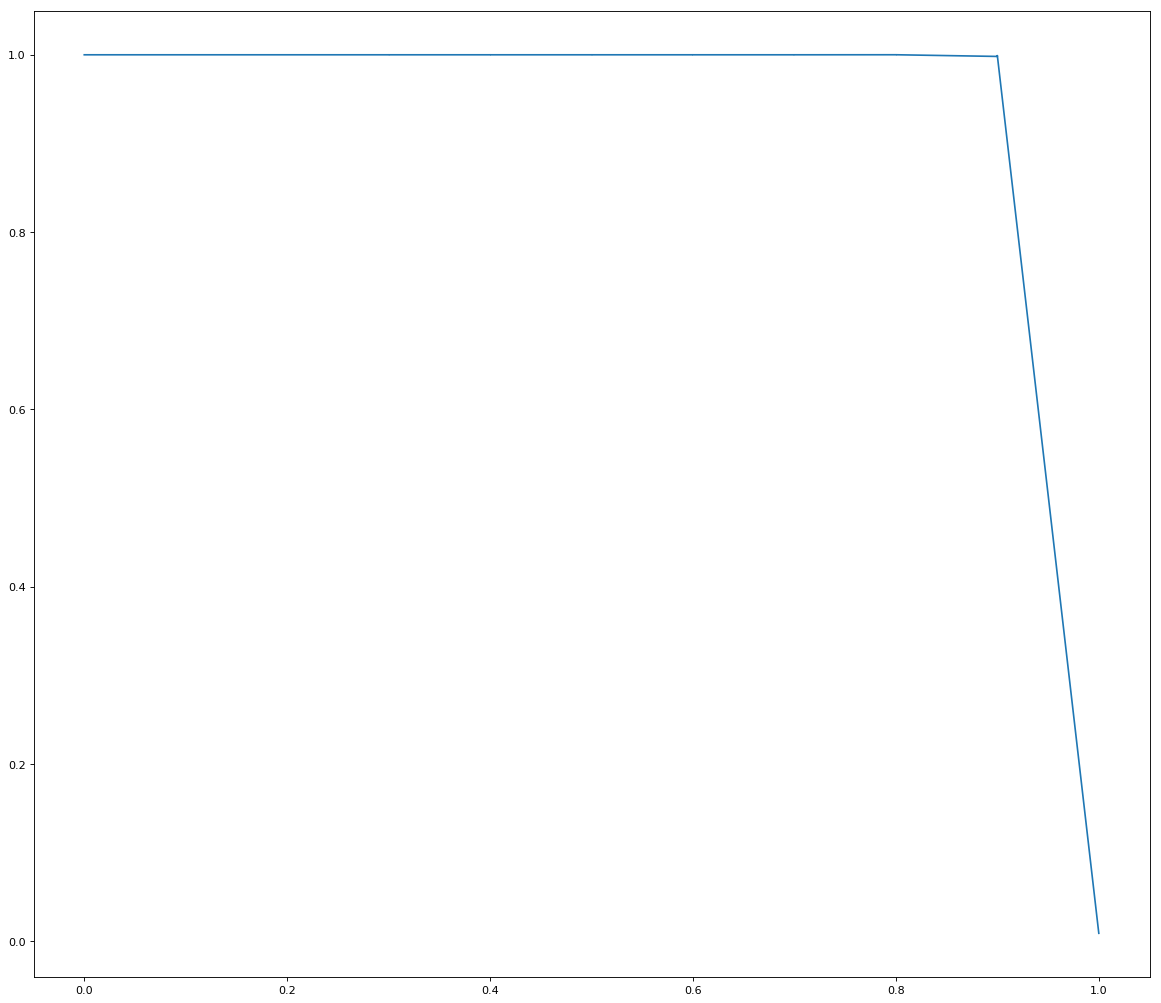

In [7]:
# plot solution
bezier = domain.sample('bezier', 9)
x, u = bezier.eval([ns.x, ns.u])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, u)
# plt.ylim(-2,2)